# OCR 라이브러리 비교하기

In [4]:
import os
import glob

import cv2

import matplotlib.pyplot as plt
import matplotlib.image as img

# keras-ocr
import keras_ocr

# tesseract
import pytesseract
from PIL import Image
from pytesseract import Output
import re

# Google OCR API
from google.cloud import vision
import io
from PIL import ImageDraw

# Step1. 검증용 데이터셋 준비

## 1-1. 서비스 기획
- 홍차 틴케이스나 패키지 사진을 입력하면 텍스트를 추출해 어떤 제품인지 알려주는 서비스를 제작해보자.
- 패키지에 필기체도 많다보니 사진에서 텍스트를 검출해 자동으로 제품 상세 정보나 가격 등을 알려줄 수 있으면 좋을 것이다.

## 1-2. 데이터셋 구축

In [6]:
data_path = os.getenv('HOME')+'/aiffel/enode18/ocr_python/tea/'

In [7]:
images_path = glob.glob(data_path+"*.jpg")
images_path

['/aiffel/aiffel/enode18/ocr_python/tea/6.jpg',
 '/aiffel/aiffel/enode18/ocr_python/tea/7.jpg',
 '/aiffel/aiffel/enode18/ocr_python/tea/10.jpg',
 '/aiffel/aiffel/enode18/ocr_python/tea/5.jpg',
 '/aiffel/aiffel/enode18/ocr_python/tea/12.jpg',
 '/aiffel/aiffel/enode18/ocr_python/tea/9.jpg',
 '/aiffel/aiffel/enode18/ocr_python/tea/13.jpg',
 '/aiffel/aiffel/enode18/ocr_python/tea/15.jpg',
 '/aiffel/aiffel/enode18/ocr_python/tea/2.jpg',
 '/aiffel/aiffel/enode18/ocr_python/tea/1.jpg',
 '/aiffel/aiffel/enode18/ocr_python/tea/4.jpg',
 '/aiffel/aiffel/enode18/ocr_python/tea/3.jpg',
 '/aiffel/aiffel/enode18/ocr_python/tea/8.jpg',
 '/aiffel/aiffel/enode18/ocr_python/tea/14.jpg',
 '/aiffel/aiffel/enode18/ocr_python/tea/11.jpg']

- 15개의 테스트 이미지를 가져왔다.

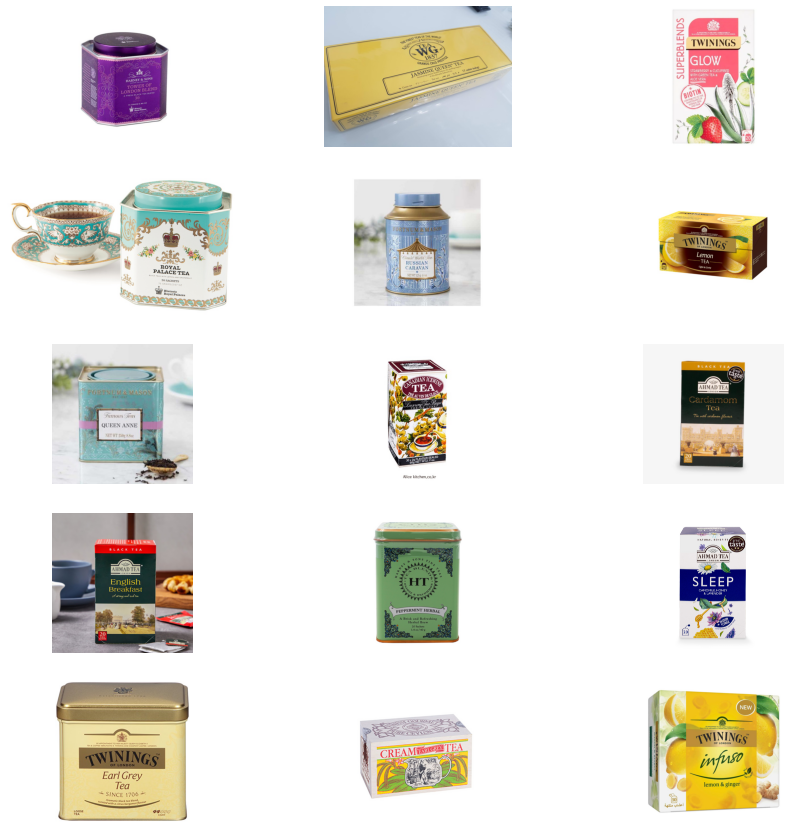

In [4]:
plt.figure(figsize=(15, 15))

for i, image in enumerate(images_path,1):
    plt.subplot(5, 3, i)
    plt.imshow(img.imread(image))
    plt.axis('off')

# Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

## 2-1. keras-ocr

In [94]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [95]:
images = [keras_ocr.tools.read(im) for im in images_path]
predictions = [pipeline.recognize([im]) for im in images_path]

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


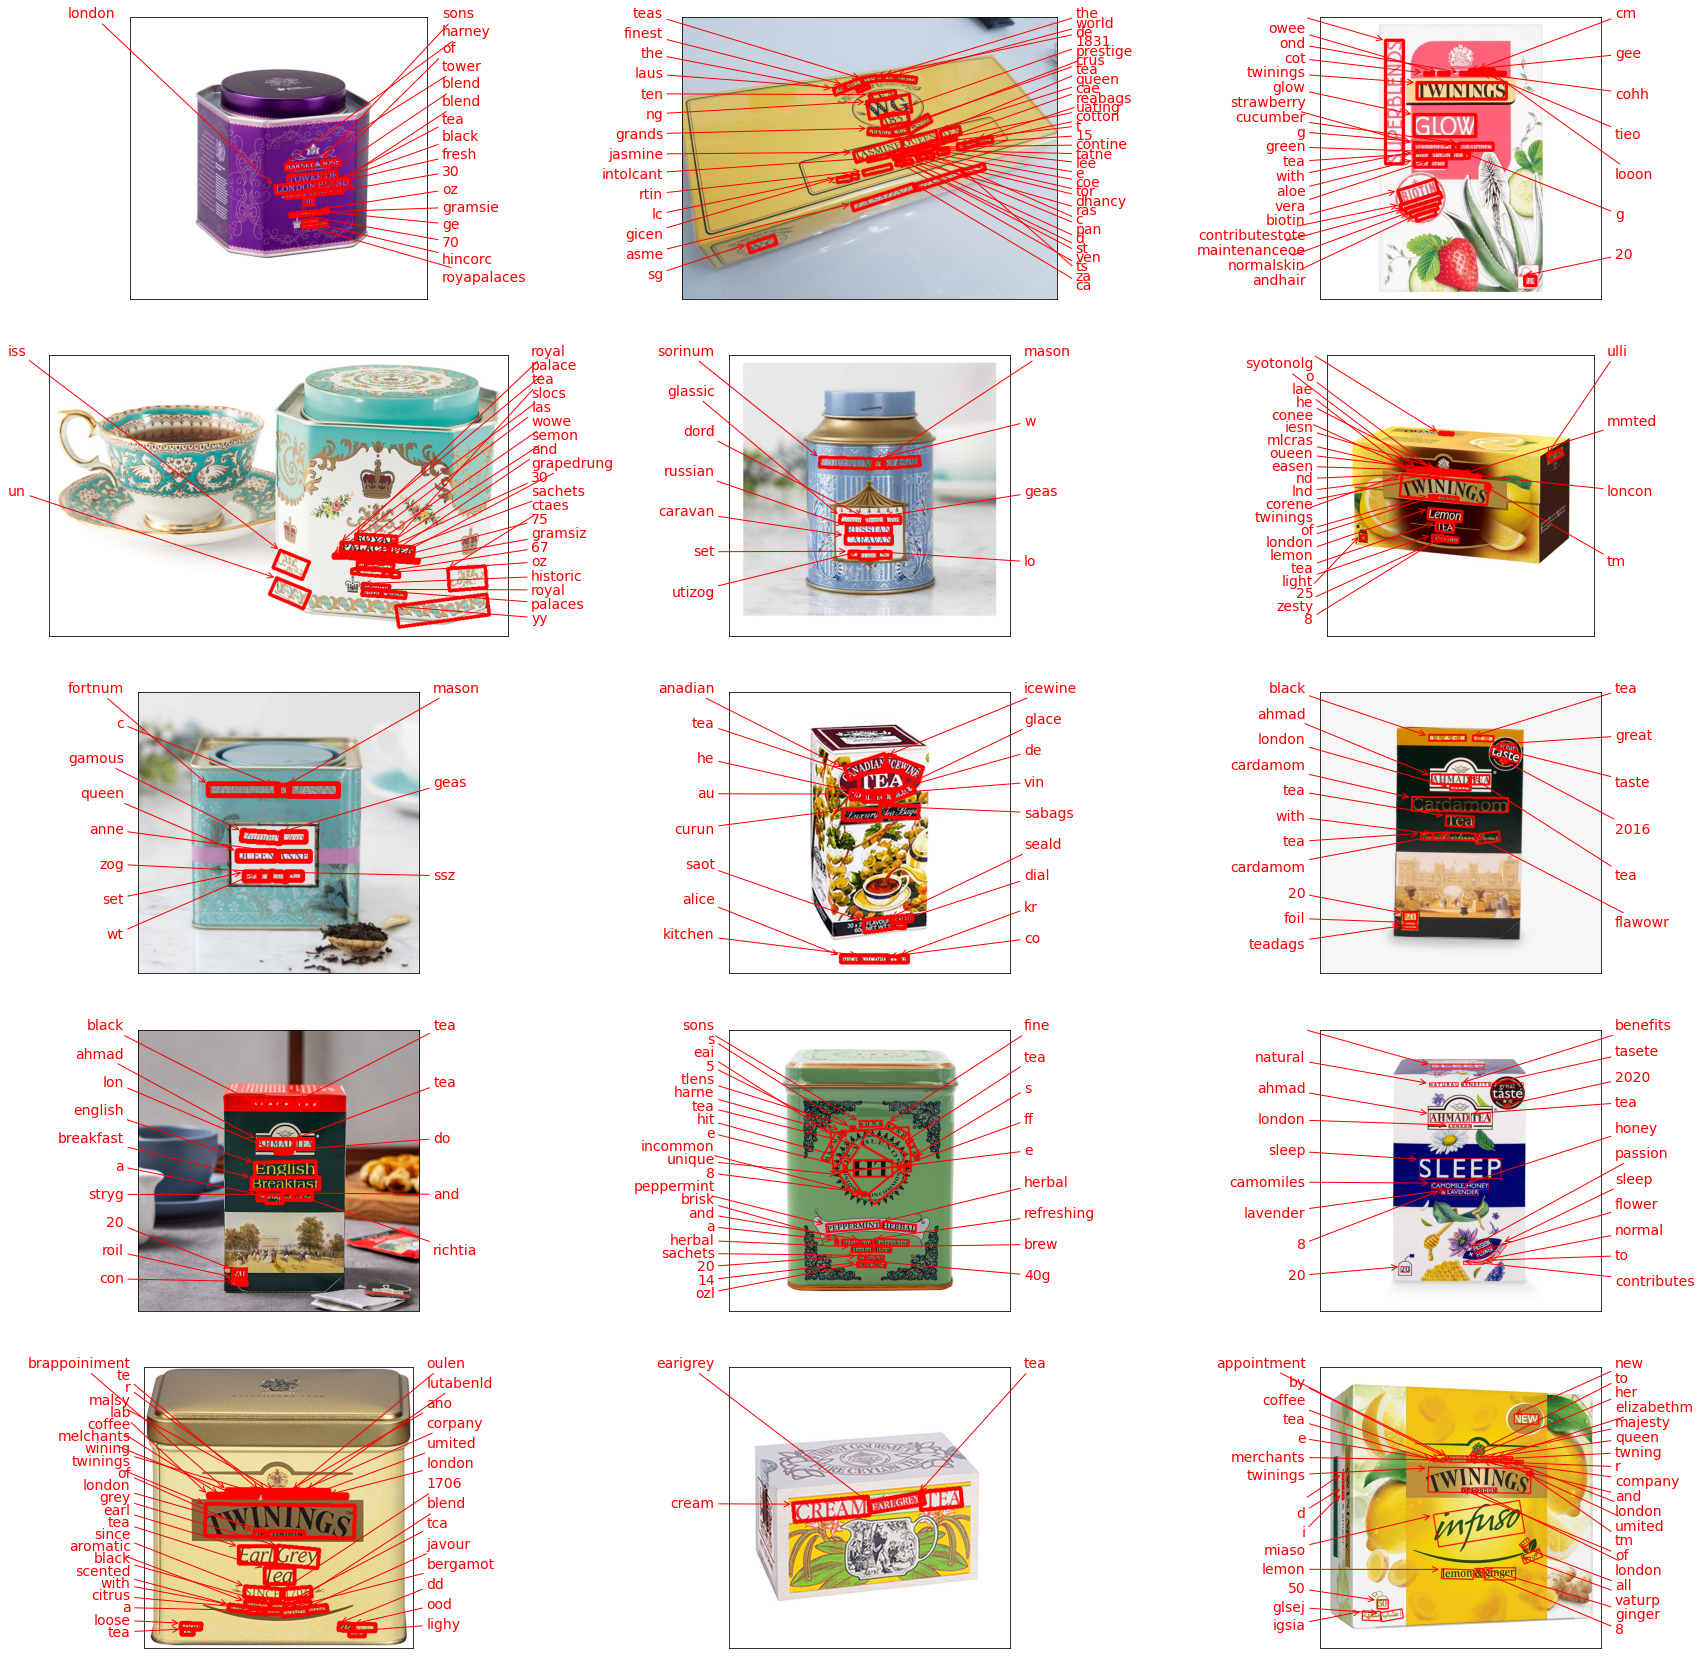

In [7]:
fig, axs = plt.subplots(5, 3, figsize=(30, 30))
for a in range(len(axs)):
    for b in range(len(axs[a])):
        keras_ocr.tools.drawAnnotations(image=images[3*a+b], 
                                    predictions=predictions[3*a+b][0], ax=axs[a,b])

- 꽤나 정교하게 인식했다.
- 그러나 네번째 이미지의 경우처럼 케이스 자체 패턴이 화려한 경우 일부 글자라고 오인식 하는 경우도 볼 수 있었다.

## 2-2. Tesseract

### 1) 테서렉트 문자 검출, 이미지 자르기

### 테서렉트 모드
#### OCR Engine modes(–oem):
- 0 - Legacy engine only.
- 1 - Neural nets LSTM engine only.
- 2 - Legacy + LSTM engines.
- 3 - Default, based on what is available.

#### Page segmentation modes(–psm):
- 0 - Orientation and script detection (OSD) only.
- 1 - Automatic page segmentation with OSD.
- 2 - Automatic page segmentation, but no OSD, or OCR.
- 3 - Fully automatic page segmentation, but no OSD. (Default)
- 4 - Assume a single column of text of variable sizes.
- 5 - Assume a single uniform block of vertically aligned text.
- 6 - Assume a single uniform block of text.
- 7 - Treat the image as a single text line.
- 8 - Treat the image as a single word.
- 9 - Treat the image as a single word in a circle.
- 10 - Treat the image as a single character.
- 11 - Sparse text. Find as much text as possible in no particular order.
- 12 - Sparse text with OSD.
- 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

- def `detect_box(image_path)`: `pytesseract.image_to_data()`를 이용해 결과를 pytesseract의 Output 딕셔너리 형식으로 받는다.
검출된 text의 개수 만큼 반복해서 검출 영역의 left, top, width, height 정보를 통해 사각형의 바운딩 박스를 그리고 검출된 text를 이미지 상에 출력하는 함수이다.

In [78]:
def detect_box(image_path):
    filename = os.path.basename(image_path)
    # read the image and get the dimensions
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    d = pytesseract.image_to_data(img, output_type=Output.DICT)
    n_boxes = len(d['text'])

    # draw the bounding boxes on the image
    for i in range(n_boxes):
        if int(d['conf'][i]) > 1: # confidence가 1 이상인 값들만
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            text = d['text'][i]
            text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
            cv2.putText(img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                        1.5, (0, 0, 255), 3)
    return img

- 처음에 confidence 임계치를 60으로 잡았는데 거의 검출되지 않는 모습을 볼 수 있어서 값을 아예 낮췄다. 그래도 검출되는 텍스트 양과 정확도는 떨어지는 편이다.

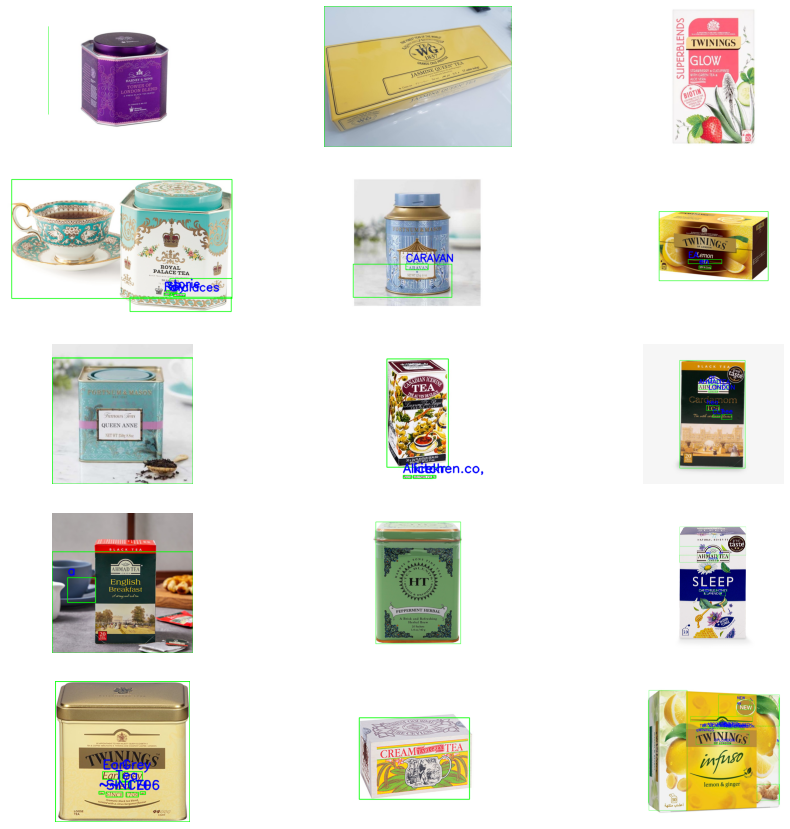

In [79]:
# confidence = 1
plt.figure(figsize=(15, 15))
for i,image_path in enumerate(images_path,1):
    img = detect_box(image_path)
    plt.subplot(5, 3, i)
    plt.imshow(img)
    plt.axis('off')

### 2) 텍스트 추출
- 앞서 한 시각화가 눈에 잘 띄지 않아 검출된 텍스트만 별도로 추출해 보기로 했다.
- def `extract_text(image_path)`: `pytesseract.image_to_string`을 사용해 검출된 문자열만 반환하는 함수.

In [62]:
def extract_text(image_path):
    custom_oem_psm_config = r'--oem 3 --psm 11'
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    txt = pytesseract.image_to_string(img, lang='eng',config=custom_oem_psm_config)
    txt = re.sub(r"\n+"," ",txt)
    return txt

- 별도로 전처리를 하지 않은 경우 너무 개행문자가 많아 정규표현식으로 거르기로 했다.

In [28]:
extract_text(images_path[1])

'RL\n\nay\n\nEe\n\n2»\n\nWN\n\n21\n\nGRANDS CRS\n\n<\n\nTER\n\nEe\n\nse\n\nSater\n\n=\n\nHE\n\nON\n\nsom,\n\nos\n\nSe\n\ncoe\n\npe\n\nLE\n\nGEA\n\nQe\n\nae\n\nKB\n\x0c'

- 역시 OCR 정확도가 떨어진다.

In [133]:
for image_path in images_path:
    filename = os.path.basename(image_path)
    txt = extract_text(image_path)
    txt = "".join([c if ord(c) < 128 else "" for c in txt]).strip()
    print(f'========{filename}========')
    print(txt)

========6.jpg========
a - sf an oa a a iY reve al TO po R OF SY Spee SX SS ON Be en 31) SS SJ Ny ete
========7.jpg========
RL ay Ee 2 WN 21 GRANDS CRS < TER Ee se Sater = HE ON som, os Se coe pe LE GEA Qe ae KB
========10.jpg========
TWININGS = i= GLOW Dacia Sarg eee Dal sha24 ALOE VERA \\ ve ay ne ~ wh N \
========5.jpg========
ae:  (CY LAs a A Roe 2 Ges a7 s ae eS aN ihe == | a AAI e ite oo ROYAL oe 30 saci i. Royal Palaces
========12.jpg========
SA (fp VA) Classi& dd Teas. RUSSIAN CARAVAN NET WTIBe Aor i) Ay an oy SL SBE
========9.jpg========
eRe iS aiton > en
========13.jpg========
rad es a iW Famous Teas QUE N ANNE } NETWT 2 88 yee a of x LES
========15.jpg========
Se , NY s ly AY Shee ty Es Alice kitchen.co, kr
========2.jpg========
BLACK T ey Se) AHMAD TEA LONDON 4 hea ta an p Las RC
========1.jpg========
erin Breakf ate,  ere i ee
========4.jpg========
Se  a pEPPE Sear]
========3.jpg========
pee ET == _ =  >  eee) eee aaa Se ee oe ee NATURAL BENEFITS gerle Vee (Oe taste ey ~~ r

## 2-3. Google OCR API

- def `detect_text(path)` : 이미지에서 문자를 검출하는 함수.
- def `draw_boxes(image, bounds, color)` : 이미지와 검출된 바운딩 박스 좌표를 받아 검출 영역 시각화.

In [103]:
def detect_text(path):
    """Detects text in the file."""
    text_dec = []
    bounds = []
    client = vision.ImageAnnotatorClient()
    
    with io.open(path, 'rb') as image_file:
        content = image_file.read()
    
    name = os.path.basename(path)
    
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations

    for text in texts:
        text_dec.append(text.description.replace('\n',''))
        vertices = text.bounding_poly
        bounds.append(vertices)
    
    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
        
    return name, text_dec, bounds

In [104]:
def draw_boxes(image, bounds, color):
    """Draw a border around the image using the hints in the vector list."""
    draw = ImageDraw.Draw(image)

    for bound in bounds:
        draw.polygon([
            bound.vertices[0].x, bound.vertices[0].y,
            bound.vertices[1].x, bound.vertices[1].y,
            bound.vertices[2].x, bound.vertices[2].y,
            bound.vertices[3].x, bound.vertices[3].y], None, color)
    return image

In [92]:
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

ls: cannot access '/aiffel/aiffel/enode18/ocr_python/my_google_api_key.json': No such file or directory


In [105]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/enode18/ocr_python/hopeful-flash-326517-995a4ddfc997.json'

In [94]:
for path in images_path:
    detect_text(path)

Texts:

"FIXE
TEAR
HARNEY & SONS
MASTER TEA BEENDERS
TOWER OF
LONDON BLEND
A FRESH BLACK TEA BLEND
30
SACHETS
75 GRAMS/2.65 Oz
n Historie
Royal Palaces
"

"FIXE"

"TEAR"

"HARNEY"

"&"

"SONS"

"MASTER"

"TEA"

"BEENDERS"

"TOWER"

"OF"

"LONDON"

"BLEND"

"A"

"FRESH"

"BLACK"

"TEA"

"BLEND"

"30"

"SACHETS"

"75"

"GRAMS/2.65"

"Oz"

"n"

"Historie"

"Royal"

"Palaces"
bounds: (432,483),(461,480),(462,489),(433,492)
Texts:

"ASIMES PTION
TEA
WG
1837
JASMINE QUEEN TEA
Intoxicating jasmine flowers enhance the sparkding edegace
of this delicanely fashioned tea
15 cotton teabags
Green tea - -74-- Thẻ vert ja - *.
JASMIINE QUEEN TEA
"

"ASIMES"

"PTION"

"TEA"

"WG"

"1837"

"JASMINE"

"QUEEN"

"TEA"

"Intoxicating"

"jasmine"

"flowers"

"enhance"

"the"

"sparkding"

"edegace"

"of"

"this"

"delicanely"

"fashioned"

"tea"

"15"

"cotton"

"teabags"

"Green"

"tea"

"-"

"-74--"

"Thẻ"

"vert"

"ja"

"-"

"*."

"JASMIINE"

"QUEEN"

"TEA"
bounds: (604,326),(642,314),(645,322),(606,334)

In [103]:
ocr_img = []
ocr_dict = {}
# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for path in images_path:
    name, text_dec, bounds = detect_text(path)
    ocr_dict[name] = text_dec
    image = Image.open(path)
    draw_boxes(image, bounds, 'red')
    ocr_img.append(image)

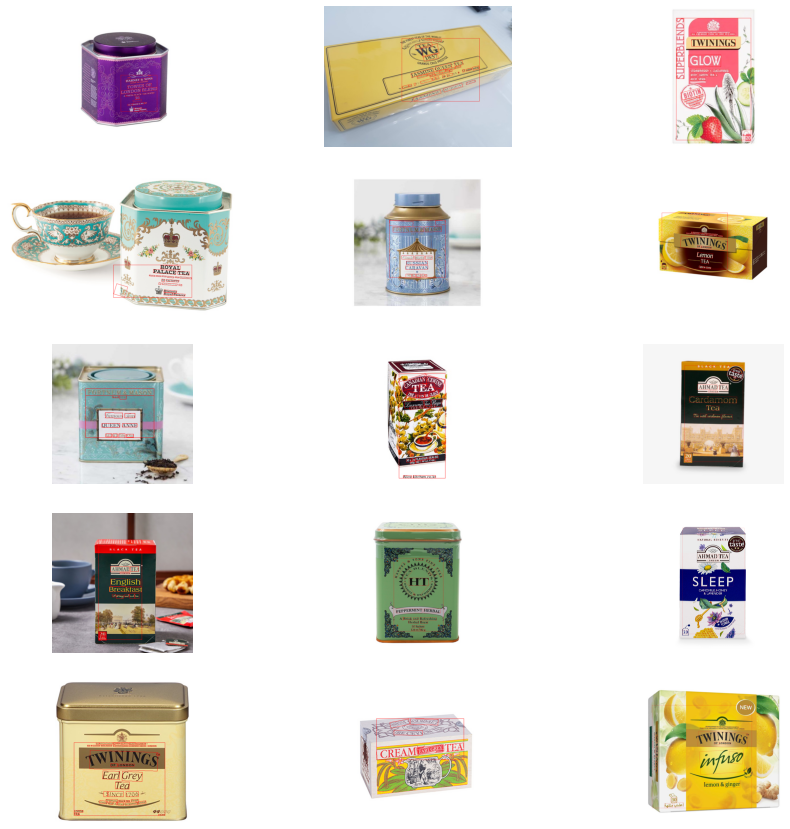

In [104]:
plt.figure(figsize=(15, 15))

for i, img in enumerate(ocr_img, 1):
    plt.subplot(5, 3, i)
    plt.imshow(img)
    plt.axis('off')

# Step3. 테스트 결과 정리

## 3-1. keras-ocr

In [96]:
def show_keras(num):
    keras_ocr.tools.drawAnnotations(image=images[num], predictions=predictions[num][0])

- 원본문장
```
ROYAL
PALACE TEA
BLACK TEAS WITH LEMON AND GRAPEFRUIT
30 SACHETS
75 GRAMS/2.67 OZ
Historic
Royall Palaces
```

- 원본 문장은 모두 인식하고 있지만 그 외의 문양 부분도 문자로 검출하는 모습을 보였다.

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


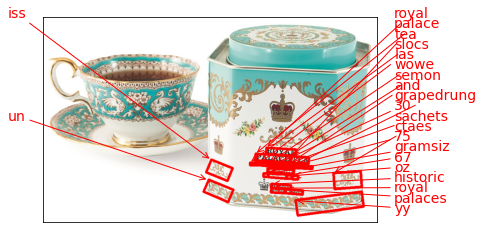

In [97]:
show_keras(3)

- 곡선의 글씨도 잘 인식하기는 하지만 이 역시 문양 부분도 문자라고 인식하는 모습을 볼 수 있다.
- 원본 문장

```
HARNEY & SONS FINE TEAS
TEA BLENDS HT
UNIQUE & UNCOMMMON
PEPPERMINT HERBAL
A Brisk and Refreshing
Herbal Brew
20 Sachets
1.4 oz / 40g
```

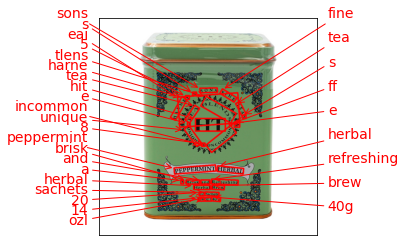

In [98]:
show_keras(10)

- 다른 api는 잘 검출하지 못했던 작은 문자도 잘 검출했다.

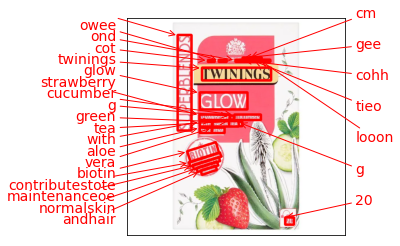

In [99]:
show_keras(2)

- 양각의 텍스트는 검출 정확도가 떨어졌다.
- 원본 문장:  `FORTNUM&MASON`

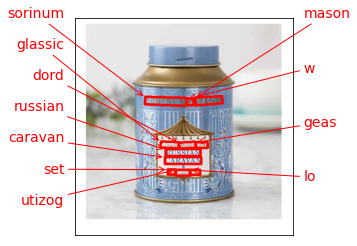

In [100]:
show_keras(4)

- 반짝이는 코팅이 들어간 텍스트도 잘 검출했다.

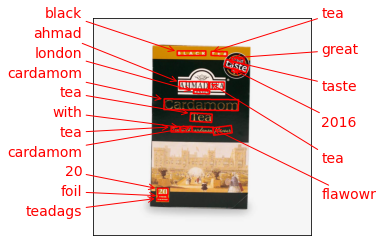

In [124]:
show_keras(8)

## 3-2 Tesseract
- 전반적으로 keras-ocr에 비해 인식률이 나빴다.
- 그 중 많은 글씨가 인식된 이미지를 자세히 보자.

In [109]:
def show_tesseract(num):
    plt.figure(figsize=(15, 15))

    plt.subplot(121)
    org = cv2.imread(images_path[num])
    org = cv2.cvtColor(org, cv2.COLOR_BGR2RGB)
    plt.imshow(org)
    plt.title('Original')
    plt.subplot(122)
    img = detect_box(images_path[num])
    plt.imshow(img)
    plt.title('Detected')
    txt = extract_text(images_path[num])
    print(txt)

- 금박 장식이 된 텍스트를 잘 검출하지 못하는 것을 볼 수 있다.

BLACK T ey Se) AHMAD TEA LONDON 4© hea ta an p Las RC 


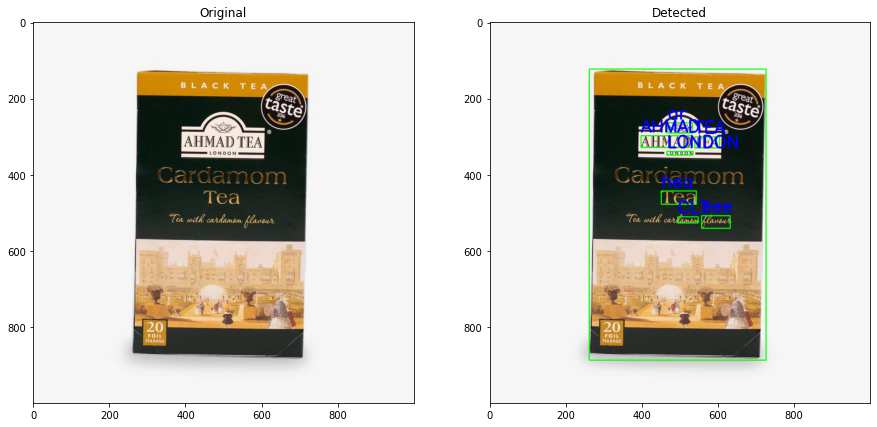

In [110]:
show_tesseract(8)

- 원본 문장
```
NEW
BY APPOINTMENT TO HER MAJESTY QUEEN ELIZABETH Ⅱ
TEA & COFFEE MERCHANTS R.TWINING AND COMPANY LIMITED.LONDON.
TWININGS ™ OF LONDON
infuse
ALL NATURAL
lemon & ginger
50
```
- 그래도 원래 문장의 많은 부분을 검출해 내고 있기는 하지만 문자가 아닌 부분을 특수 문자로 인식하는 경향이 존재했다.

[ a Y hea iN Nae 4 2) i TEA & eons MERCHANTS R. TWINING AND COMPANY LIMITED. LONDON. APPOINTMENT TO HER MAJESTY QUEEN ELIZABETH II i fi aa i i 4 WINING OF LONDON 1 im | - wa mis lemon & ginger ~ Foie wy” ee sia! 2 50 | 4e8Sie GbLis) = = 


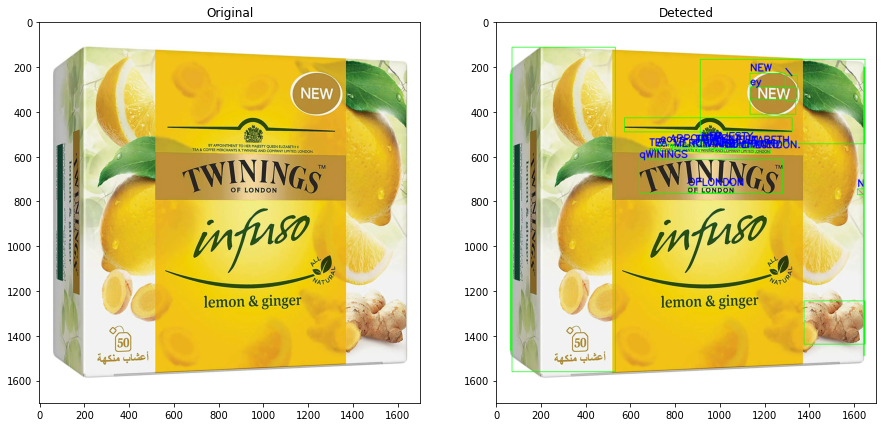

In [111]:
show_tesseract(-1)

- 문자열을 인식하기는 하지만 문자가 아닌 부분을 특수기호로 검출해내는 경우가 잦았다.

pee ET == —_— = — > —— eee) eee aaa Se ee oe ee NATURAL BENEFITS gerle Vee (Oe taste ey ~~ res MAD TEA : LONDON Lo cect = hem SLEEP CAMOMILE, HONEY & LAVENDER Cul eee SS) = PDAS WN) we S X\\3 contributes *° i ( eg 


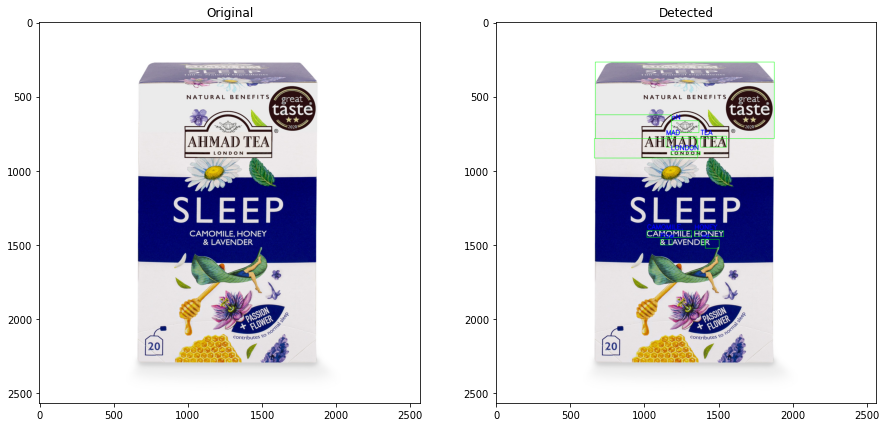

In [112]:
show_tesseract(11)

- 양각 텍스트는 아예 검출하지 못했다.

SA (fp VA) Classi& dd Teas. RUSSIAN CARAVAN NET WTIBe Aor i) Ay an oy SL SBE 


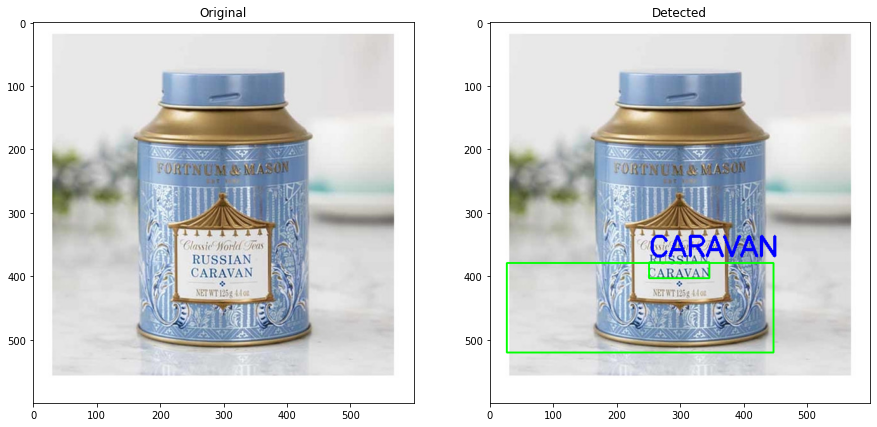

In [113]:
show_tesseract(4)

## 3-3. Google OCR API
- 확실히 유료 서비스여서 그런지 검출된 텍스트에 특수문자 등이 제일 덜 섞여 있었다.
- 위의 두 OCR 라이브러리가 정확하게 검출하지 못했던 양각 브랜드 명도 잘 찾아냈다.

In [107]:
def show_google(num):
    name, text_dec, bounds = detect_text(images_path[num])
    image = Image.open(images_path[num])
    
    plt.figure(figsize=(15, 15))
    plt.subplot(121)
    org = image
    plt.imshow(org)
    plt.title('Original')
    plt.subplot(122)
    img = draw_boxes(image, bounds, 'red')
    plt.imshow(img)
    plt.title('Detected')
    print(text_dec[0])

AVAWFORTNUM& MASONVAClassic World TeasRUSSIANCARAVANNET WT 125g 44 or


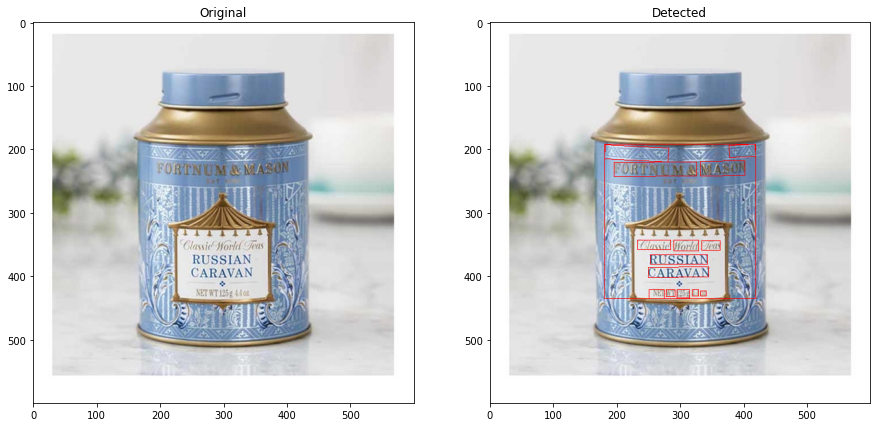

In [108]:
show_google(4)

ATHn M D.SL E E PNa turaNATURAL BENEFITSgreattăste2020AHMAD TEALONDONSLSLEEPCAMOMILE, HONEY& LAVENDERPASSIONFLOWERnormal sleep20Contributes to


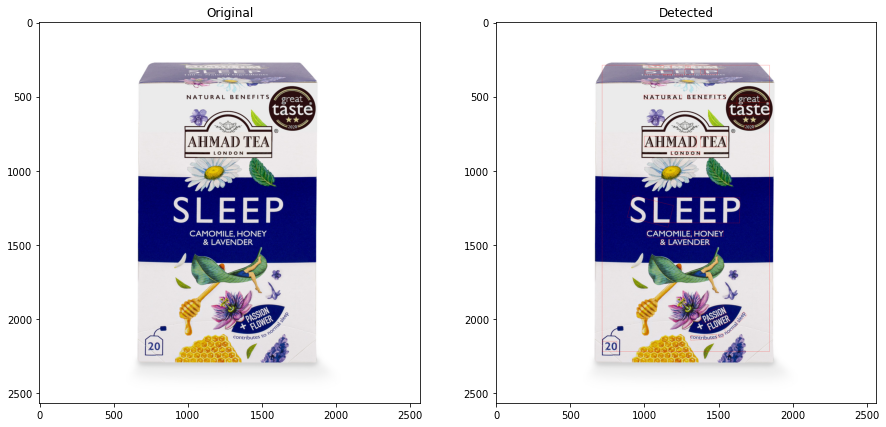

In [134]:
show_google(11)

# Step4. 결과 분석과 결론 제시
- 차 케이스 사진으로 제품 정보를 검색해주는 서비스를 위해서는 제품명과 세부 맛에 관련된 텍스트를 정확하게 검출해야한다.
- 특수문자 부분은 전처리해서 지울 수 있으니 최대한 많은 텍스트를 인식하는지 여부를 보자.
### 분석 기준
1. 브랜드명을 정확히 검출했는지
2. 핵심 맛 정보를 정확히 검출했는지
3. 티백 개수, 무게 등 상세 정보를 검출했는지
|이미지|keras-ocr|tesseract|Google OCR API|
|-:|:--:|:--:|:--:|
|0|o/o/o|x/x/x|o/o/o|
|1|x/o/o|x/x/x|o/o/o|
|2|o/o/o|x/x/o|o/o/o|
|3|o/x/o|x/o/x|o/o/o|
|4|x/o/x|x/o/x|o/o/o|
|5|o/o/o|x/x/x|o/o/o|
|6|o/o/x|x/o/x|o/o/o|
|7|x/o/x|x/x/x|o/o/o|
|8|o/o/o|o/x/x|o/o/o|
|9|o/o/o|x/x/x|o/o/o|
|10|o/o/o|x/x/x|o/o/o|
|11|o/o/o|x/o/x|o/o/o|
|12|o/o/o|x/o/x|o/o/o|
|13|o/x/x|x/x/x|o/o/o|
|14|o/o/o|o/o/o|o/o/o|

- Google OCR API의 결과가 월등히 우수했다.
- tesseract는 사용하기 어려운 수준의 정확도를 보였다.
- 비용이 걱정된다면 keras-ocr로 적당히 타협을 보는 것도 좋은 대안일 것이다.

- 서비스가 고도의 정확도를 요구하다면 Google OCR API를 사용할 것이고, 비용 절감이 더 우선인 경우 keras-ocr을 사용하는 것이 적합해 보인다.

# 회고
- 라이브러리 마다 반환 값 형태가 조금씩 달라서 시각화하기 까다로웠다. 다양한 반환값에 맞게 시각화 하는 법을 알아둬야겠다.
- 그래도 데이터가 많은 영어인데도 정확도가 이 정도인데 한글 OCR 제품의 정확도를 향상시키려면 얼마나 힘들까..!
- 사용하고 있는 무료 OCR 앱 중에 정확도가 꽤 높은 제품이 있는데 어떻게 만들어졌는지 너무 궁금하다. 오픈소스 라이선스를 까봐야할 듯.